In [2]:
import pandas as pd
import numpy as np
import os
import datetime
today = datetime.datetime.now().strftime("%Y%m%d")

# create a word cloud from the review comments
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from matplotlib.font_manager import FontProperties
import matplotlib.ticker as mtick
import string
import re
import os
import pandas as pd
import numpy as np
import spacy
import gc
font = FontProperties()
font.set_family('serif')
font.set_name('Times New Roman')

In [3]:
graphicfolder = "./figures"
if not os.path.exists(graphicfolder):
    os.makedirs(graphicfolder)

# Goal: use simple statistics based NLP methods to analyze the paper published recently
* Learn simple usage of NLTK python package
* understand the PMI (pointwise mutual information) score
## Content:
1. Download all article abstracts from Webofscience: 1900 + articles
2. Visualize most frequently used biagrams in all research papers


In [4]:
# Run these below to install the library and packages
# !python -m spacy download en_core_web_sm
# !python -m spacy download en_core_web_lg
# !pip install spacy
# !pip install wordcloud
# !pip install nltk

In [5]:
import nltk
# nltk.download('averaged_perceptron_tagger')

In [6]:
# load the data
DF = pd.read_csv('data/abstracts-machine learning urban planning-20231203-1932rows.csv', index_col=0)
DF = DF[~DF['Abstract'].isna()].reset_index(drop = True)

## 1. Tokenize the text
**tokenisation**:Tokenisation is the process of breaking up a given text into units called tokens. Tokens can be individual words, phrases or even whole sentences. In the process of tokenization, some characters like punctuation marks may be discarded.

In [7]:
#extract only reviews
en_stopwords = set(stopwords.words('english'))
def get_one_class(DF):
    # value is a list
    comments = DF['Abstract']
    comments = comments.astype('str')
    
    #function to remove non-ascii characters
    def _removeNonAscii(s): return "".join(i for i in s if ord(i)<128)
    #remove non-ascii characters
    comments = comments.map(lambda x: _removeNonAscii(x))
    print(comments.shape[0])
    #get stop words of all languages
    STOPWORDS_DICT = {lang: set(nltk.corpus.stopwords.words(lang)) for lang in nltk.corpus.stopwords.fileids()}
    #function to detect language based on # of stop words for particular language
    def get_language(text):
        words = set(nltk.wordpunct_tokenize(text.lower()))
        lang = max(((lang, len(words & stopwords)) for lang, stopwords in STOPWORDS_DICT.items()), key = lambda x: x[1])[0]
        if lang == 'english':
            return True
        else:
            return False
        
    return comments

def get_tokens(eng_comments):
    #load spacy
    nlp = spacy.load("en_core_web_sm")

    #function to clean and lemmatize comments
    def clean_comments(text):
        #remove punctuations
        regex = re.compile('[' + re.escape(string.punctuation) + '\\r\\t\\n]')
        nopunct = regex.sub(" ", str(text))
        #use spacy to lemmatize comments
        doc = nlp(nopunct, disable=['parser','ner'])
        lemma = [token.lemma_ for token in doc]
        return lemma

    #apply function to clean and lemmatize comments
    lemmatized = eng_comments.map(clean_comments)

    #make sure to lowercase everything
    lemmatized = lemmatized.map(lambda x: [word.lower() for word in x])

    #turn all comments' tokens into one single list
    unlist_comments = [item for items in lemmatized for item in items]
    return lemmatized, unlist_comments

def rightTypes(ngram, en_stopwords = en_stopwords):
    if '-pron-' in ngram or '' in ngram or ' 'in ngram or 't' in ngram:
        return False
    for word in ngram:
        if word in en_stopwords:
            return False
    acceptable_types = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    second_type = ('NN', 'NNS', 'NNP', 'NNPS')
    tags = nltk.pos_tag(ngram)
    if tags[0][1] in acceptable_types and tags[1][1] in second_type:
        return True
    else:
        return False
    
def rightTypesTri(ngram):
    """This function takes in a trigram and returns True if it is a noun phrase, False otherwise"""
    if '-pron-' in ngram or '' in ngram or ' 'in ngram or '  ' in ngram or 't' in ngram:
        return False
    for word in ngram:
        if word in en_stopwords:
            return False
    first_type = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    third_type = ('JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS')
    tags = nltk.pos_tag(ngram)
    if tags[0][1] in first_type and tags[2][1] in third_type:
        return True
    else:
        return False



## 2. Create PMI for biagram

1. What is PMI? [SOURCE](https://medium.com/@bekirufuk/creating-a-pmi-dictionary-for-multiple-documents-using-nltk-b3be4bf31f8e).

PMI metric depends on occurrences of words (or events in a more general sense) by themselves and co-occurrences with others. It is represented by the simple formula below.
<p align="center">
<img src="../asset/PMI.webp" alt="pmi" style="width:50%; border:0;">
</p>
While w1 and w2 represent the two words that we see the PMI score of, P(w1) and P(w2) represent their frequencies throughout the corpus, and P(w1, w2) represents the frequency of their co-occurrence.
Then we multiply the PMI and frequency for each bigram to compute a normalized density score.

In [8]:
# Breakdown the steps
# clean up the abstract
comments = get_one_class(DF)
# lemmatize the abstract
lemmatized, unlist_comments = get_tokens(comments)


1931


In [9]:
# load the nltk bigram and trigram measures
bigrams = nltk.collocations.BigramAssocMeasures()
bigramFinder = nltk.collocations.BigramCollocationFinder.from_words(unlist_comments)

In [10]:
#create a table of bigram collocations and bigram frequency
bigram_freq = bigramFinder.ngram_fd.items()
bigramFreqTable = pd.DataFrame(list(bigram_freq), columns=['bigram','freq']).sort_values(by='freq', ascending=False)
bigramFreqTable

,bigram,freq
186,"( , the)",5722
208,"( , and)",4263
2,"(of, the)",3151
561,"(in, the)",1975
2028,"( , we)",1764
...,...,...
69923,"(ability, rather)",1
69922,"(extraordinary, ability)",1
69921,"(these, extraordinary)",1
69920,"(inadequate, with)",1


In [11]:
# drop the bigrams that contain stopwords from the libary first
filtered_bi = bigramFreqTable[bigramFreqTable.bigram.map(lambda x: rightTypes(x, en_stopwords))]

In [12]:
#filter for only those with more than 20 occurences
bigramFinder.apply_freq_filter(20)

In [13]:
bigramPMITable = pd.DataFrame(list(bigramFinder.score_ngrams(bigrams.pmi)), 
                                columns=['bigram','PMI']).sort_values(by='PMI', ascending=False)

# merge the bigramPMITable and big
mergedbig = filtered_bi.merge(bigramPMITable, on = 'bigram', how = 'inner')
mergedbig['freqxPMI'] = mergedbig['freq'] * mergedbig['PMI']
mergedbig = mergedbig.sort_values(by = 'freqxPMI', ascending = False)
mergedbig

,bigram,freq,PMI,freqxPMI
0,"(machine, learning)",933,7.345193,6853.065228
1,"(machine, learn)",897,7.489745,6718.301081
3,"(neural, network)",522,8.768114,4576.955555
2,"(land, use)",632,5.680729,3590.220795
4,"(result, show)",441,6.793418,2995.897196
...,...,...,...,...
398,"(approach, use)",23,1.308068,30.085575
337,"(method, use)",26,0.768626,19.984286
448,"(urban, datum)",21,0.025614,0.537887
405,"(datum, use)",23,-0.109723,-2.523637


In [14]:
# we join the text for each bigram
mergedbig['text'] = mergedbig['bigram'].map(lambda x: ' '.join(x))
taskdict = dict(zip(mergedbig['text'], mergedbig['freqxPMI']))

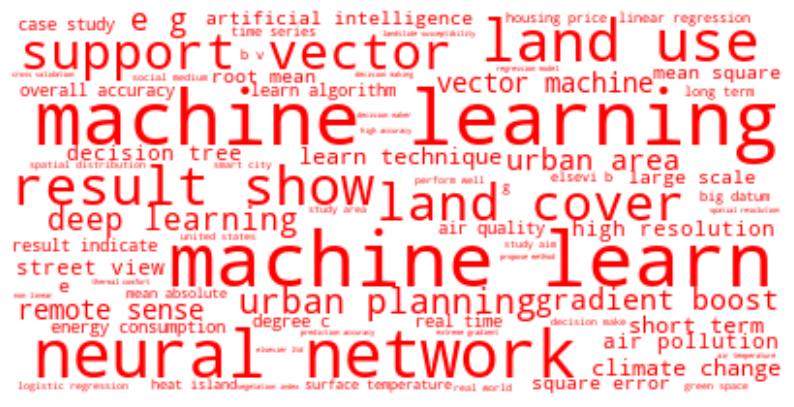

In [15]:
# create wordcloud using the taskdict
wordcloud = WordCloud(max_font_size=50, max_words=100, 
                      background_color="white",
                      prefer_horizontal=1, 
                      # change color_func to change the color of the word cloud
                        color_func=lambda *args, **kwargs: "red"
                      )
wordcloud.fit_words(taskdict)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [16]:
# Let's remove some buzz word
drop1 = [
    "deep learning",
    "machine learning",
    "machine learn",
    "neural network",
    "artificial intelligence",
    "artificial neural",
    "support vector",
    "e g",
    "natural language",
    "result show",
    "gradient boost",
    "result indicate",
    "vector machine",
    "decision tree",
    "mean square",
    "square root",
    "r squre",
    "mean absolut",
    "b v",
    "elsevi b",
    "square error",
    "root mean",
    "learn algorithm",
    "learn technique",
]

mergedbig_update = mergedbig[mergedbig['text'].isin(drop1) == False].reset_index(drop =True)
taskdict = dict(zip(mergedbig_update['text'], mergedbig_update['freqxPMI']))

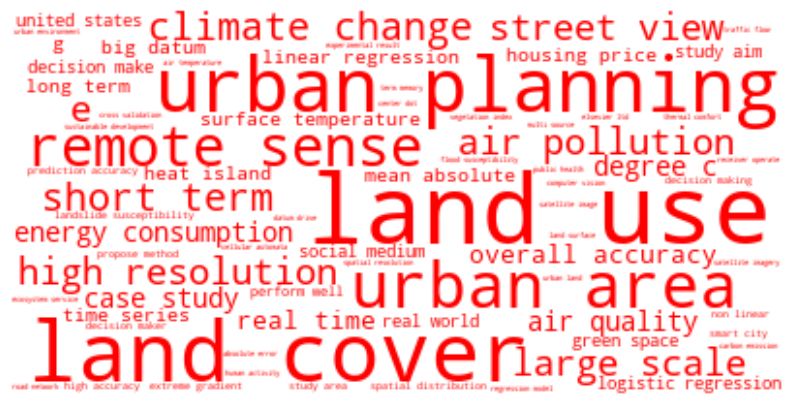

In [17]:
# create wordcloud using the taskdict
wordcloud = WordCloud(max_font_size=50, max_words=100, 
                      background_color="white",
                      prefer_horizontal=1, 
                      # change color_func to change the color of the word cloud
                        color_func=lambda *args, **kwargs: "red"
                      )
wordcloud.fit_words(taskdict)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Full code in one function below:

In [8]:
def get_word_rank(DF, 
                  en_stopwords = en_stopwords):
    comments = get_one_class(DF)
    _, unlist_comments = get_tokens(comments)
    bigrams = nltk.collocations.BigramAssocMeasures()
    trigrams = nltk.collocations.TrigramAssocMeasures()
    bigramFinder = nltk.collocations.BigramCollocationFinder.from_words(unlist_comments)
    trigramFinder = nltk.collocations.TrigramCollocationFinder.from_words(unlist_comments)

    #bigrams
    bigram_freq = bigramFinder.ngram_fd.items()
    bigramFreqTable = pd.DataFrame(list(bigram_freq), columns=['bigram','freq']).sort_values(by='freq', ascending=False)
    #trigrams
    trigram_freq = trigramFinder.ngram_fd.items()
    trigramFreqTable = pd.DataFrame(list(trigram_freq), columns=['trigram','freq']).sort_values(by='freq', ascending=False)
    
    filtered_bi = bigramFreqTable[bigramFreqTable.bigram.map(lambda x: rightTypes(x, en_stopwords))]
    # filtered_tri = trigramFreqTable[trigramFreqTable.trigram.map(lambda x: rightTypesTri(x, en_stopwords))]
    
    #filter for only those with more than 20 occurences
    bigramFinder.apply_freq_filter(20)
    # trigramFinder.apply_freq_filter(20)
    bigramPMITable = pd.DataFrame(list(bigramFinder.score_ngrams(bigrams.pmi)), 
                                columns=['bigram','PMI']).sort_values(by='PMI', ascending=False)
    # trigramPMITable = pd.DataFrame(list(trigramFinder.score_ngrams(trigrams.pmi)), 
    #                             columns=['trigram','PMI']).sort_values(by='PMI', ascending=False)
    # merge the bigramPMITable and big
    mergedbig = filtered_bi.merge(bigramPMITable, on = 'bigram', how = 'inner')
    mergedbig['freqxPMI'] = mergedbig['freq'] * mergedbig['PMI']
    mergedbig = mergedbig.sort_values(by = 'freqxPMI', ascending = False)
    
    # merge the trigramPMITable and trig
    # mergedtri = filtered_tri.merge(trigramPMITable, on = 'trigram', how = 'inner')
    # mergedtri['freqxPMI'] = mergedtri['freq'] * mergedtri['PMI']
    # mergedtri = mergedtri.sort_values(by = 'freqxPMI', ascending = False)
    return mergedbig
# , mergedtri

In [9]:
mergedbig= get_word_rank(DF)

1931


In [10]:
drop1 = [
    "deep learning",
    "machine learning",
    "machine learn",
    "neural network",
    "artificial intelligence",
    "artificial neural",
    "support vector",
    "e g",
    "natural language",
    "result show",
    "gradient boost",
    "result indicate",
    "vector machine",
    "decision tree",
    "mean square",
    "square root",
    "r squre",
    "mean absolut",
    "b v",
    "elsevi b",
    "square error",
    "root mean",
    "learn algorithm",
    "learn technique",
]

In [11]:
dropwords = drop1.copy()
mergedbig['text'] = mergedbig['bigram'].map(lambda x: ' '.join(x))
mergedbig_update = mergedbig[mergedbig['text'].isin(dropwords) == False].reset_index(drop =True)
# mergedbig_update = mergedbig.copy()
taskdict = dict(zip(mergedbig_update['text'], mergedbig_update['freqxPMI']))

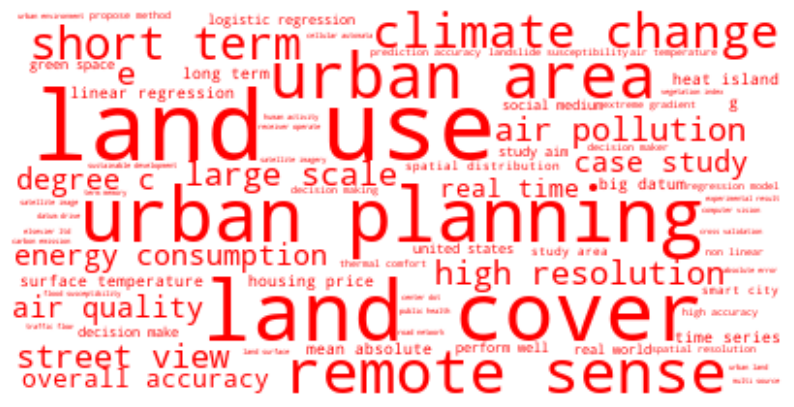

In [12]:
# create wordcloud using the taskdict
wordcloud = WordCloud(max_font_size=50, max_words=100, 
                      background_color="white",
                      prefer_horizontal=1, 
                      # change color_func to change the color of the word cloud
                        color_func=lambda *args, **kwargs: "red"
                      )
wordcloud.fit_words(taskdict)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Experiment with Scattertext
[Source](https://github.com/JasonKessler/scattertext)
A tool for finding distinguishing terms in corpora and displaying them in an interactive HTML scatter plot. Points corresponding to terms are selectively labeled so that they don't overlap with other labels or points.

Cite as: Jason S. Kessler. Scattertext: a Browser-Based Tool for Visualizing how Corpora Differ. ACL System Demonstrations. 2017.

In [19]:
import scattertext as st


c:\Users\yuanzfan\Anaconda3\envs\pitaya\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
# !pip install scattertext
DF.columns

Index(['Article Title', 'Source Title', 'Reprint Addresses', 'Author Keywords',
       'Keywords Plus', 'Abstract', 'Publication Year', 'UT (Unique WOS ID)',
       'Web of Science Record', 'WoS Categories', 'DOI'],
      dtype='object')

### Test dispersion measures
**dispersion**: the degree to which occurrences of a word are distributed throughout a corpus evenly or unevenly/clumpily.

In [21]:
DF['parsed'] = DF['Abstract'].apply(st.whitespace_nlp_with_sentences)
DF['parsed']

0       (as, evidence, of, the, contextual, effects, o...
1       (initiated, by, the, university, consortium, o...
2       (improvements, of, machine, learning, -, based...
3       (earthquake, prediction, is, a, popular, topic...
4       (land, use, and, land, cover, (, lulc, ), info...
                              ...                        
1926    (3d, city, modeling, is, an, interesting, subj...
1927    (the, combination, of, rapid, urbanization, ,,...
1928    (injuries, have, become, devastating, and, oft...
1929    (sustainable, urban, growth, advocates, the, i...
1930    (although, reliable, and, accurate, inventoryi...
Name: parsed, Length: 1931, dtype: object

In [20]:
corpus = (st.CorpusWithoutCategoriesFromParsedDocuments(DF, 
                              parsed_col = 'parsed')
          .build()
          .get_unigram_corpus()
          .remove_infrequent_words(minimum_term_count=6))
dispersion = st.Dispersion(corpus)

dispersion_df = dispersion.get_df()
dispersion_df.head(3)

,Frequency,Range,SD,VC,Juilland's D,Rosengren's S,DP,DP norm,KL-divergence
as,2549,1275,1.399899,1.060496,0.976003,0.625882,0.395723,0.395791,0.796855
evidence,79,65,0.240584,5.880615,0.861991,0.033030,0.965062,0.965229,5.007508
of,16444,1930,4.136477,0.485742,0.990471,0.955674,0.161898,0.161926,0.122992


In [21]:
dispersion_df = dispersion_df.assign(
    X=lambda df: df.Frequency,
    Xpos=lambda df: st.Scalers.log_scale(df.X),
    Y=lambda df: df["Rosengren's S"],
    Ypos=lambda df: st.Scalers.scale(df.Y),
)

In [25]:
html = st.dataframe_scattertext(
    corpus,
    plot_df=dispersion_df,
    metadata=corpus.get_df()['Source Title'] + ' (' + corpus.get_df()['WoS Categories'].str.upper() + ')',
    ignore_categories=True,
    x_label='Log Frequency',
    y_label="Rosengren's S",
    y_axis_labels=['Less Dispersion', 'Medium', 'More Dispersion'],
)
# show html in jupyter notebook
from IPython.display import IFrame
file_name = "./figures/word_dispersion.html"
open(file_name, 'wb').write(html.encode('utf-8'))
# IFrame(src=file_name, width=1300, height=700)

<p align="center">
<img src="../asset/text_scatter_results.png" alt="results_simple" style="width:80%; border:0;">
</p>